###Mount Goodgle Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


###Select folder with notebook. A data folder to contain the samples should be visible

In [ ]:
### for go up directory
%cd ..
### to go to directory
%cd ./gdrive/My Drive/Colab Notebooks
%ls

/
/gdrive/My Drive/Colab Notebooks
CancerDetection.ipynb  model_transfer.pt         sample_predictions.csv
data/                  model_transfer_VGG299.pt  train_out/
get_results.py         model_VGG.pt              Untitled
ground_truth.csv       __pycache__/              Untitled0.ipynb
model_inception.pt     requirements.txt          valid_out/
model_Resnet.pt        results.csv


###Download the datasets and unzip into data folder

In [ ]:
!wget "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"

In [ ]:
!unzip '/gdrive/My Drive/Colab Notebooks/test.zip' -d '/gdrive/My Drive/Colab Notebooks/data/'

In [ ]:
!wget "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"

--2020-07-22 21:23:31--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.16
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5736557430 (5.3G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   5.34G  38.2MB/s    in 2m 19s  

2020-07-22 21:25:50 (39.5 MB/s) - ‘train.zip’ saved [5736557430/5736557430]



In [ ]:
!unzip '/gdrive/My Drive/Colab Notebooks/train.zip' -d '/gdrive/My Drive/Colab Notebooks/data/'

In [ ]:
!wget "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"

In [ ]:
!unzip '/gdrive/My Drive/Colab Notebooks/valid.zip' -d '/gdrive/My Drive/Colab Notebooks/data/'

###Import the necessary librairies and count available samples

In [ ]:
import numpy as np
import os
from glob import glob
import pandas as pd
from PIL import Image, ImageFile
from tqdm import tqdm, tnrange
from tqdm import tqdm_notebook as tqdm
import torch
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

###Set the device as CUDA or CPU

In [ ]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

###Explore the data

In [ ]:
# load filenames for images
train_files = np.array(glob('data/train/*/*'))
valid_files = np.array(glob("data/valid/*/*"))
test_files = np.array(glob("data/test/*/*"))

# print number of images in each dataset
print('There are %d total train images.' % len(train_files))
print('There are %d total validation images.' % len(valid_files))
print('There are %d total test images.' % len(test_files))

There are 1880 total train images.
There are 134 total validation images.
There are 600 total test images.


###Display a few of the samples

data/train/seborrheic_keratosis/ISIC_0012291.jpg
(2848, 4288, 3)
[35 38 40] [251 255 255]
data/train/seborrheic_keratosis/ISIC_0012217.jpg
(2000, 3008, 3)
[ 9 20 67] [207 209 217]
data/train/seborrheic_keratosis/ISIC_0012299.jpg
(2000, 3008, 3)
[ 35  61 113] [255 255 255]


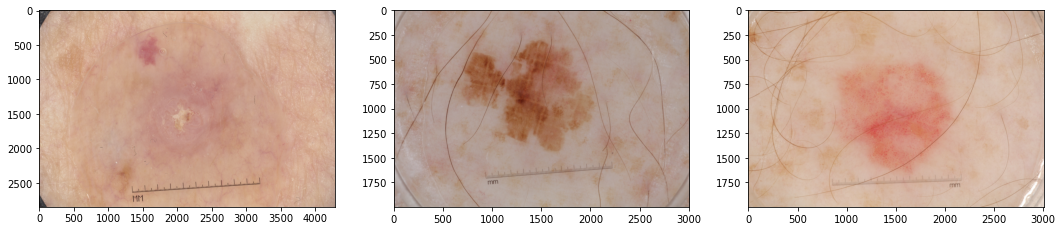

In [ ]:
import cv2                
import matplotlib.pyplot as plt                           

plt.figure(figsize=(18,9))
for index, img_path in enumerate(train_files[:3]):
    plt.subplot(1,3, index+1)
    print(img_path)
    img = cv2.imread(img_path)
    print(img.shape)
    print(img.min(axis=(0,1)), img.max(axis=(0,1)))                 # images are within [0,255] and must be scaled to [0,1] for pytorch pretrained models
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
plt.show()

##train dataset is squewed towards Nevus - Let's calculate corrective weights to apply during training

In [ ]:
labels=['melanoma', 'nevus', 'seborrheic_keratosis']
counts=np.zeros_like(labels)
for index, label in enumerate(labels):
    counts[index] = (len(np.array(glob('data/train/'+label+'/*'))))
    print('number of ',label,' images: ',counts[index])

number of  melanoma  images:  362
number of  nevus  images:  1273
number of  seborrheic_keratosis  images:  245


In [ ]:
counts = counts.astype(np.float)
median_freq=np.median(counts)
class_weights=np.zeros_like(labels, dtype=np.float)
print('Corrective weights to account for dataset over-representation of Nevus')
for index, label in enumerate(labels):
    class_weights[index]=median_freq / counts[index]
    print(label,' : ',class_weights[index])

class_weights = torch.FloatTensor(class_weights)
if use_cuda:
    class_weights = class_weights.cuda()

Corrective weights to account for dataset over-representation of Nevus
melanoma  :  1.0
nevus  :  0.28436763550667715
seborrheic_keratosis  :  1.4775510204081632


###Set dataloader with appropriate image transformations. I use data augmentation

In [ ]:
def get_loaders (input_img_dim):
  num_workers = 0

  data_dir = 'data/'
  train_dir = os.path.join(data_dir, 'train/')
  valid_dir = os.path.join(data_dir, 'valid/')
  test_dir = os.path.join(data_dir, 'test/')

  train_transform = transforms.Compose([transforms.Resize((input_img_dim+50,input_img_dim+50)),                                               
                                        transforms.RandomHorizontalFlip(0.5),
                                        transforms.RandomVerticalFlip(0.5),
                                        transforms.RandomRotation(45),
                                        transforms.CenterCrop(input_img_dim),    
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                            std=(0.229, 0.224, 0.225))])   # Pytorch default backend for images are Pillow. when using ToTensor(), PyTorch automatically converts all images into [0,1]

  valid_transform = transforms.Compose([transforms.Resize((input_img_dim+1,input_img_dim+1)),
                                        transforms.CenterCrop(input_img_dim),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                            std=(0.229, 0.224, 0.225))])

  test_transform = transforms.Compose([transforms.Resize((input_img_dim+1,input_img_dim+1)),
                                      transforms.CenterCrop(input_img_dim),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                          std=(0.229, 0.224, 0.225))])

  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=47, shuffle=True, num_workers=num_workers)
  valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=67, shuffle=False, num_workers=num_workers)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=25, shuffle=False, num_workers=num_workers)

  return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Train and Validate the Model


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, is_inception=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            #print('.', end='')
            optimizer.zero_grad()

            if is_inception:
              output, aux_output = model(data)
              loss1 = criterion(output, target)
              loss2 = criterion(aux_output, target)
              loss = loss1 + 0.4 * loss2                 # 0.4 is weight for auxillary classifier in Inception V3
            else:
              output = model(data)
              loss = criterion(output, target)

            loss.backward()
            optimizer.step()
            
            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        
        scheduler.step()
            
    # return trained model
    return model

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(tqdm(loaders['test'])):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target).item()
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


### (IMPLEMENTATION) Model Architecture
---
In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html).  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  
You are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).

In [ ]:
num_classes = 3

## Specify model architecture 
model_VGG = models.vgg16(pretrained=True)
print(model_VGG)

for param in model_VGG.features.parameters():               # freeze feature parameters of pre-trained VGG16 model
    param.requires_grad = False
model_VGG.classifier[6] = nn.Linear(4096, num_classes)
print(model_VGG)

if use_cuda:
    model_VGG = model_VGG.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### (IMPLEMENTATION) Specify Loss Function and Optimizer


In [ ]:
loaders=get_loaders(224)

In [ ]:
criterion = nn.CrossEntropyLoss()                                    # In Pytorch, CrossEntropyLoss combines a Logsoftmax with a NLLLoss
optimizer = optim.Adam(model_VGG.classifier.parameters(), lr=0.0001, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
# train the model
model_VGG = train(30, loaders, model_VGG, optimizer, criterion, use_cuda, 'model_VGG.pt', is_inception=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 1 	Training Loss: 0.818990 	Validation Loss: 1.112157



Epoch: 2 	Training Loss: 0.725044 	Validation Loss: 0.935828



Epoch: 3 	Training Loss: 0.669769 	Validation Loss: 0.902248



Epoch: 4 	Training Loss: 0.659198 	Validation Loss: 0.901264



Epoch: 5 	Training Loss: 0.644178 	Validation Loss: 0.888416



Epoch: 6 	Training Loss: 0.611620 	Validation Loss: 0.904603



Epoch: 7 	Training Loss: 0.600390 	Validation Loss: 0.886817



Epoch: 8 	Training Loss: 0.599283 	Validation Loss: 0.916152



Epoch: 9 	Training Loss: 0.586119 	Validation Loss: 0.910412



Epoch: 10 	Training Loss: 0.582151 	Validation Loss: 0.998407



Epoch: 11 	Training Loss: 0.582540 	Validation Loss: 0.922687



Epoch: 12 	Training Loss: 0.557992 	Validation Loss: 0.924497



Epoch: 13 	Training Loss: 0.558118 	Validation Loss: 0.922328



Epoch: 14 	Training Loss: 0.548448 	Validation Loss: 0.909198



Epoch: 15 	Training Loss: 0.552449 	Validation Loss: 0.911914


### (IMPLEMENTATION) Test the Model

Calculate and print the test loss and accuracy.

In [ ]:
# load the model that got the best validation accuracy (uncomment the line below)
model_VGG.load_state_dict(torch.load('model_VGG.pt'))

<All keys matched successfully>

In [ ]:
test(loaders, model_VGG, criterion, use_cuda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Test Loss: 0.796678


Test Accuracy: 67% (403/600)


###Obtain Pre-trained Inception V3 Model
The code cell below downloads the model, along with weights that have been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of 1000 categories.

In [ ]:
## Specify model architecture 

num_classes = 3

model_inception = models.inception_v3(pretrained=True, aux_logits=True)             # Be careful, InceptionV3 expects (299,299) sized images and has auxiliary output
print(model_inception)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth



Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, 

###Modify both output layers of Inception model for the classification task
- aux_ouput
- fully connected layer

In [ ]:
for param in model_inception.parameters():               # freeze feature parameters of pre-trained VGG16 model
    param.requires_grad = False

model_inception.AuxLogits.fc = nn.Linear(768, num_classes)

BasicConv2d = nn.Sequential(OrderedDict([('conv', nn.Conv2d(2048, 192, kernel_size=(1,1), stride=(1,1))),
                                         ('bn', nn.BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True))]))

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                         ('relu', nn.ReLU()),
                                         ('drop', nn.Dropout(0.5)),
                                         ('fc2', nn.Linear(512, num_classes)) 
                                         ]))                                                # ('output', nn.Softmax(dim=1))

model_inception.Mixed_7c.branch_pool = BasicConv2d
model_inception.fc = classifier
print(model_inception)

if use_cuda:
    model_inception = model_inception.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [ ]:
loaders=get_loaders(input_img_dim=299)

In [ ]:
dataiter = iter(loaders['train'])
images, labels = dataiter.next()
print(images.shape, labels.shape)

torch.Size([47, 3, 299, 299]) torch.Size([47])


In [ ]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss(weight=class_weights)          # combines a Logsoftmax
params_to_update = [{'params': model_inception.Mixed_7c.branch_pool.parameters()}, {'params': model_inception.AuxLogits.fc.parameters()}, {'params': model_inception.fc.parameters()}]
#optimizer = optim.RMSprop(params_to_update, lr=0.00001, momentum=0, weight_decay=1e-5)
optimizer = optim.Adam(params_to_update, lr=0.0001, betas=(0.9,0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
# train the model
model_inception = train(15, loaders, model_inception, optimizer, criterion, use_cuda, 'model_inception.pt', is_inception=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 1 	Training Loss: 1.072630 	Validation Loss: 0.929786



Epoch: 2 	Training Loss: 0.981157 	Validation Loss: 0.901117



Epoch: 3 	Training Loss: 0.960264 	Validation Loss: 0.918977



Epoch: 4 	Training Loss: 0.932720 	Validation Loss: 0.906038



Epoch: 5 	Training Loss: 0.921047 	Validation Loss: 0.897870



Epoch: 6 	Training Loss: 0.896927 	Validation Loss: 0.932065



Epoch: 7 	Training Loss: 0.879381 	Validation Loss: 0.886987



Epoch: 8 	Training Loss: 0.867894 	Validation Loss: 0.872881



Epoch: 9 	Training Loss: 0.851687 	Validation Loss: 0.874104



Epoch: 10 	Training Loss: 0.837082 	Validation Loss: 0.867941



Epoch: 11 	Training Loss: 0.832936 	Validation Loss: 0.908994



Epoch: 12 	Training Loss: 0.820069 	Validation Loss: 0.850429



Epoch: 13 	Training Loss: 0.831986 	Validation Loss: 0.890765



Epoch: 14 	Training Loss: 0.809150 	Validation Loss: 0.872515



Epoch: 15 	Training Loss: 0.795747 	Validation Loss: 0.847705


In [ ]:
model_inception.load_state_dict(torch.load('model_inception.pt'))

<All keys matched successfully>

In [ ]:
test(loaders, model_inception, criterion, use_cuda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Test Loss: 0.755589


Test Accuracy: 70% (421/600)


###Testing with ResNet152 pre-trained model

In [ ]:
model_Resnet= models.resnet152(pretrained = True)

for param in model_Resnet.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('Dropout',nn.Dropout(0.45)),
                          ('fc2', nn.Linear(512, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model_Resnet.fc = classifier
print(model_Resnet)
if use_cuda:
    model_Resnet = model_Resnet.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
loaders=get_loaders(input_img_dim=224)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_Resnet.fc.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
model_Resnet = train(15, loaders, model_Resnet, optimizer, criterion, use_cuda, 'model_Resnet.pt', is_inception=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch: 1 	Training Loss: 0.842914 	Validation Loss: 1.018018



Epoch: 2 	Training Loss: 0.746312 	Validation Loss: 0.870932



Epoch: 3 	Training Loss: 0.717031 	Validation Loss: 1.060187



Epoch: 4 	Training Loss: 0.686836 	Validation Loss: 0.861836



Epoch: 5 	Training Loss: 0.699482 	Validation Loss: 0.987560



Epoch: 6 	Training Loss: 0.687115 	Validation Loss: 0.861554



Epoch: 7 	Training Loss: 0.666334 	Validation Loss: 0.942174



Epoch: 8 	Training Loss: 0.654593 	Validation Loss: 0.899456



Epoch: 9 	Training Loss: 0.641079 	Validation Loss: 0.877735



Epoch: 10 	Training Loss: 0.651608 	Validation Loss: 0.854682



Epoch: 11 	Training Loss: 0.657757 	Validation Loss: 1.018530



Epoch: 12 	Training Loss: 0.634786 	Validation Loss: 0.968037



Epoch: 13 	Training Loss: 0.630042 	Validation Loss: 0.936492



Epoch: 14 	Training Loss: 0.633741 	Validation Loss: 0.956359



Epoch: 15 	Training Loss: 0.633274 	Validation Loss: 1.021400


In [ ]:
model_Resnet.load_state_dict(torch.load('model_Resnet.pt'))
test(loaders, model_Resnet, criterion, use_cuda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Test Loss: 0.726997


Test Accuracy: 67% (407/600)


##Display example of inherence output format for get_results.py (performance evaluation)

In [ ]:
true_labels = pd.read_csv("ground_truth.csv", sep=",", header=0, index_col=0)
print(list(true_labels))
true_labels.head(5)

['task_1', 'task_2']


,task_1,task_2
Id,,
data/test/melanoma/ISIC_0012258.jpg,1,0
data/test/melanoma/ISIC_0012356.jpg,1,0
data/test/melanoma/ISIC_0012369.jpg,1,0
data/test/melanoma/ISIC_0012395.jpg,1,0
data/test/melanoma/ISIC_0012425.jpg,1,0


##Get predictions and prepare results file

In [ ]:
def test_transform_img(img, input_img_dim):
  test_transform = transforms.Compose([transforms.Resize((input_img_dim+1,input_img_dim+1)),
                                      transforms.CenterCrop(input_img_dim),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                          std=(0.229, 0.224, 0.225))])
  return test_transform(img)

def get_image(img_path, input_img_dim):
  image = Image.open(img_path)
  image = test_transform_img(image, input_img_dim)
  image = image.requires_grad_(True)
  #image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)                         # add batch dimension
  return image

In [ ]:
def get_predictions(model, path_to_files, input_img_dim=224):
  if use_cuda:
    model = model.cuda()
  model.eval()
  score_1 = []
  score_2 = []
  for img_path in tqdm(path_to_files):
    img = get_image(img_path, input_img_dim)
    if use_cuda:
      img = img.cuda()
    pred = model(img).cpu().detach().numpy()
    score_1.append(float(pred[0][0]))
    score_2.append(float(pred[0][2]))
  return score_1, score_2 

In [ ]:
print("getting predictions on all test images:")
score_1, score_2 = get_predictions(model_inception, test_files, input_img_dim=299)

import csv
        
with open('results.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['Id', 'task_1', 'task_2'])
  for i in range(len(test_files)):
    doc.writerow([test_files[i], score_1[i], score_2[i]])


getting predictions on all test images:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


### Evaluate predictions and Plot scores

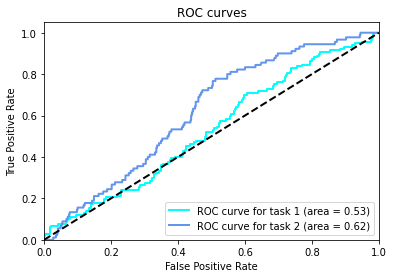

Category 1 Score: 0.528
Category 2 Score: 0.618
Category 3 Score: 0.573


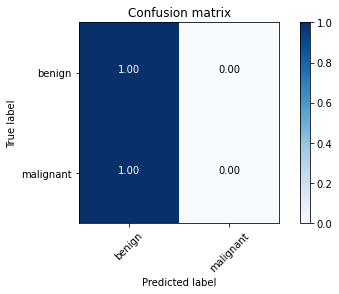

In [ ]:
import sys
import itertools
import get_results as results

threshold = 0.5 

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth[["task_1", "task_2"]].values

# get model predictions for test dataset
y_pred = pd.read_csv('results.csv')
y_pred = y_pred[["task_1", "task_2"]].values

# plot ROC curves and print scores
results.plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
results.plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)